# W207: Forest Cover - KNN

## Plan

1. No feature engineering, just k=1, 5, 10, 20, 25 any difference;
2. PCA to reduce dimensions to 2 or 3 and try KNN;
3. StandardScaler and try KNN;
4. StandardScaler and PCA (which one first, may need to try both) and try KNN with different k;
5. Use only continuous features and remove categorical features;

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# 0. Read Data

In [2]:
df_all_train = pd.read_csv('train.csv')
df_all_test = pd.read_csv('test.csv')

print df_all_train.shape, df_all_test.shape

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_all_train, random_state=1)

print df_train.shape, df_test.shape

(15120, 56) (565892, 55)
(11340, 56) (3780, 56)


In [3]:
df_train.Cover_Type.value_counts()

5    1647
6    1631
3    1630
7    1628
1    1608
2    1599
4    1597
Name: Cover_Type, dtype: int64

In [4]:
df_test.Cover_Type.value_counts()

4    563
2    561
1    552
7    532
3    530
6    529
5    513
Name: Cover_Type, dtype: int64

In [5]:
feature_columns = df_all_test.columns

X_all_train = df_all_train[feature_columns]
X_all_test = df_all_test[feature_columns]

X_train = df_train[feature_columns]
X_test = df_test[feature_columns]

y_all_train = df_all_train.Cover_Type
y_train = df_train.Cover_Type
y_test = df_test.Cover_Type

# 1. KNN - vanilla

1. KNN without any feature engineering

2. First train it using X_train and check accuracy on X_test

3. Then train it using X_all_train and predict on X_all_test and check scores on Kaggle

n=1 :  0.06475

n=2 :  0.06475

n=5 :  0.06475

n=10:  0.06475

n=15:  0.06475

n=20:  0.06475

n=25:  0.06475

#### Note 
PKB submission using logistic regression score is 0.49604

In [6]:
# Test Code
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
F1_score_train = f1_score(y_train, knn.predict(X_train), average='weighted').round(4)
F1_score_test = f1_score(y_test, knn.predict(X_test), average='weighted').round(4)

y_hat_train = knn.predict(X_train)
y_hat_test = knn.predict(X_test)

accuracy_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)

print F1_score_train
print F1_score_test

print accuracy_test

1.0
0.8426
0.8452


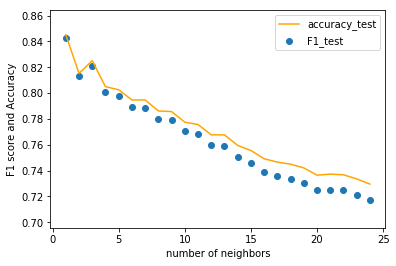

In [7]:
# Code to find F1, Accuracy as function of neighbors
F1_test = []
accuracy_test = []

for n in range(1,25):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)  
    
    y_hat_test = knn.predict(X_test)
    
    F1_score_test = f1_score(y_test, knn.predict(X_test), average='weighted').round(4)    
    acc_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)
    
    F1_test.append(F1_score_test)
    accuracy_test.append(acc_test)

plt.scatter(range(1,25), F1_test, label = 'F1_test')
plt.plot(range(1,25), accuracy_test, label = 'accuracy_test', color='orange')
plt.xlabel('number of neighbors')
plt.ylabel('F1 score and Accuracy')
plt.legend()
plt.show()

In [8]:
# Using X_all_train to train KNN with n = 1, 2, 5, 10, 15, 20
# predict X_all_test, write to csv, submit to Kaggle for evaluation
n = 3

knn1 = KNeighborsClassifier(n_neighbors = n)
knn1.fit(X_all_train, y_all_train)  

pred = knn.predict(df_all_test)
ID = df_all_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('test_submission_knn1_n_'+ str(n) + '.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

# 2. KNN - PCA

Using PCA to reduce dimensions and try KNN

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#ss = StandardScaler()
#X_scaled = ss.fit_transform(X)
from sklearn.pipeline import Pipeline

def get_knn2_accuracy(pca_num, knn_num):
    pca2 = PCA(n_components=pca_num)
    knn2 = KNeighborsClassifier(n_neighbors=knn_num)
    pipe2 = Pipeline(steps = [
        ('pca', pca2),
        ('knn', knn2)])
    pipe2.fit(X_train, y_train)
    y_hat_test = pipe2.predict(X_test)
    acc_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)
    return acc_test

In [10]:
# Run the grid and create a dataframe with the results

pca_comp = []
knn_comp = []
mod_accu = []

# Run the grid
for pca_num in [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]:
    for knn_num in [1, 2, 5, 10, 15, 20, 25]:
      
            pca_comp.append(pca_num)
            knn_comp.append(knn_num)
            m_acc = get_knn2_accuracy(pca_num, knn_num)
            mod_accu.append(m_acc)
            #print pca_num, knn_num, m_acc

# Create a dataframe for the results from the lists            
knn2_tuples = list(zip(pca_comp, knn_comp, mod_accu))
knn2df = pd.DataFrame(knn2_tuples, columns=['PCA_comp', 'KNN_comp', 'mod_accuracy'])

In [11]:
knn2df.sort_values(by='mod_accuracy', ascending=False).head()

,PCA_comp,KNN_comp,mod_accuracy
28,15,1,0.8452
84,55,1,0.8452
21,10,1,0.8452
63,40,1,0.8452
70,45,1,0.8452


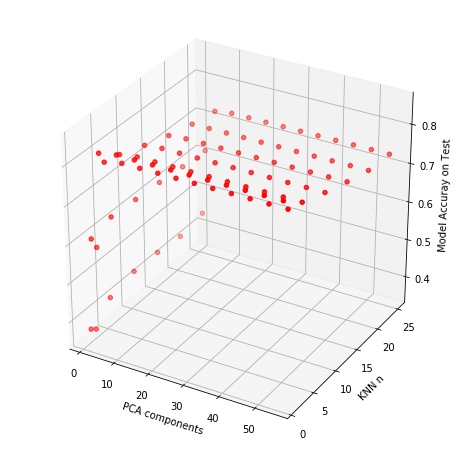

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(pca_comp, knn_comp, mod_accu, c='r', marker='o')

ax1.set_xlabel('PCA components')
ax1.set_ylabel('KNN n')
ax1.set_zlabel('Model Accuray on Test')

plt.show()

In [45]:
# Using X_all_train to train KNN with n = 1, 2, 5, 10, 15, 20
# predict X_all_test, write to csv, submit to Kaggle for evaluation
pca_num = 3
knn_num = 20

pca2 = PCA(n_components=pca_num)
knn2 = KNeighborsClassifier(n_neighbors=knn_num)

pipe2 = Pipeline(steps = [
    ('pca', pca2),
    ('knn', knn2)])
pipe2.fit(X_all_train, y_all_train)

pred = pipe2.predict(df_all_test)
ID = df_all_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('test_submission_knn2_p_'+ str(pca_num) +'_n_' + str(knn_num) + '.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

## KNN2 Kaggle scores summary

### PCA = 1

- knn=1, score = 0.05936

- knn=2, score = 0.05936

- knn=5, score = 0.05936

- knn=10, score = 0.05936

- knn=20, score = 0.05936


### PCA = 2

- knn=1, score = 0.08146

- knn=2, score = 0.07127

- knn=5, score = 0.06727

- knn=10, score = 0.06600

- knn=20, score = 0.06677


### PCA = 3

- knn=1, score = 0.07616

- knn=2, score = 0.07168

- knn=5, score = 0.06987

- knn=10, score = 0.06730

- knn=20, score = 0.06686


### PCA=5

- knn=1, score = 0.07664

- knn=2, score = 0.07158

- knn=5, score = 0.07074

- knn=10, score = 0.06992

- knn=20, score = 0.06637


### PCA = 10

- knn=1, score = 0.07667

- knn=2, score = 0.07161

- knn=5, score = 0.07075

- knn=10, score = 0.06690

- knn=20, score = 0.06637


# 3. KNN - scaling

Try scaling before KNN

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#ss = StandardScaler()
#X_scaled = ss.fit_transform(X)
from sklearn.pipeline import Pipeline

def get_knn3_accuracy(pca_num, knn_num):
    ss3 = StandardScaler()
    knn3 = KNeighborsClassifier(n_neighbors=knn_num)
    pipe3 = Pipeline(steps = [
        ('ss', ss3),
        ('knn', knn3)])
    pipe3.fit(X_train, y_train)
    y_hat_test = pipe3.predict(X_test)
    acc_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)
    return acc_test

In [14]:
# Run the grid and create a dataframe with the results
knn3_comp = []
mod3_accu = []

# Run the grid

for knn_num in [1, 2, 5, 10, 15, 20, 25]:
    knn3_comp.append(knn_num)
    m_acc = get_knn2_accuracy(pca_num, knn_num)
    mod3_accu.append(m_acc)
    #print pca_num, knn_num, m_acc

# Create a dataframe for the results from the lists            
knn3_tuples = list(zip(knn3_comp, mod3_accu))
knn3df = pd.DataFrame(knn3_tuples, columns=['KNN_comp', 'mod_accuracy'])

In [15]:
knn3df

,KNN_comp,mod_accuracy
0,1,0.8452
1,2,0.8153
2,5,0.8026
3,10,0.7775
4,15,0.7556
5,20,0.7365
6,25,0.7307


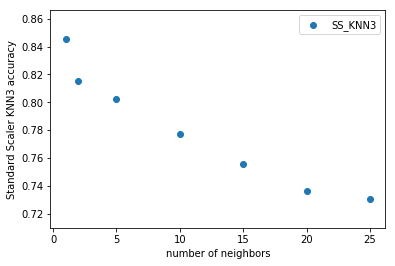

In [16]:
plt.scatter(knn3df.KNN_comp, knn3df.mod_accuracy, label = 'SS_KNN3')
plt.xlabel('number of neighbors')
plt.ylabel('Standard Scaler KNN3 accuracy')
plt.legend()
plt.show()

In [50]:
# Using X_all_train to train KNN with n = 1, 2, 5, 10, 15, 20
# predict X_all_test, write to csv, submit to Kaggle for evaluation

knn_num = 20

ss3 = StandardScaler()
knn3 = KNeighborsClassifier(n_neighbors=knn_num)
pipe3 = Pipeline(steps = [
    ('ss', ss3),
    ('knn', knn3)])
pipe3.fit(X_all_train, y_all_train)

pred = pipe3.predict(df_all_test)
ID = df_all_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('test_submission_knn3_ss_'+'_n_' + str(knn_num) + '.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

## KNN3 Kaggle scores summary

## Model Fitting is Slow!!!

knn=1, score = 0.47992

knn=2, score = 0.49291

knn=5, score = 0.47094

knn=10, score = 0.4626

knn=20, score = 0.45203


# 4. KNN: scaling + PCA

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def get_knn4_accuracy(pca_num, knn_num):
    ss4 = StandardScaler()
    pca4 = PCA(n_components=pca_num)    
    knn4 = KNeighborsClassifier(n_neighbors=knn_num)
    pipe4 = Pipeline(steps = [
        ('ss', ss4),
        ('pca', pca4),
        ('knn', knn4)])
    pipe4.fit(X_train, y_train)
    y_hat_test = pipe4.predict(X_test)
    acc_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)
    return acc_test

In [18]:
pca4_comp = []
knn4_comp = []
mod4_accu = []

# Run the grid
for pca_num in [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]:
    for knn_num in [1, 2, 5, 10, 15, 20, 25]:
      
            pca4_comp.append(pca_num)
            knn4_comp.append(knn_num)
            m_acc = get_knn4_accuracy(pca_num, knn_num)
            mod4_accu.append(m_acc)
            #print pca_num, knn_num, m_acc

# Create a dataframe for the results from the lists            
knn4_tuples = list(zip(pca4_comp, knn4_comp, mod4_accu))
knn4df = pd.DataFrame(knn4_tuples, columns=['PCA_comp', 'KNN_comp', 'mod_accuracy'])

In [19]:
knn4df.sort_values(by='mod_accuracy', ascending=False).head(10)

,PCA_comp,KNN_comp,mod_accuracy
84,55,1,0.7952
77,50,1,0.7952
70,45,1,0.7799
78,50,2,0.7664
85,55,2,0.7664
86,55,5,0.7577
79,50,5,0.7571
71,45,2,0.7542
56,35,1,0.7532
49,30,1,0.7524


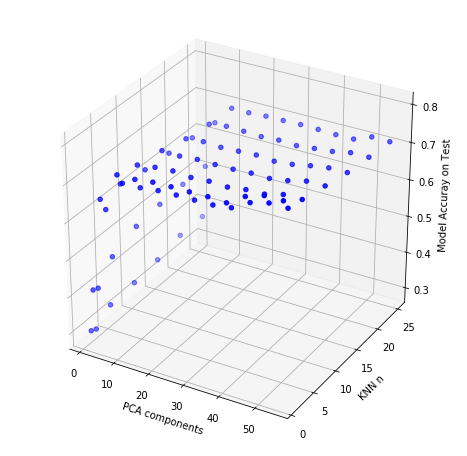

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(pca4_comp, knn4_comp, mod4_accu, c='b', marker='o')


ax1.set_xlabel('PCA components')
ax1.set_ylabel('KNN n')
ax1.set_zlabel('Model Accuray on Test')

plt.show()

In [60]:
# Using X_all_train to train KNN with n = 1, 2, 5, 10, 15, 20
# predict X_all_test, write to csv, submit to Kaggle for evaluation
pca_num = 5
knn_num = 20

ss4 = StandardScaler()
pca4 = PCA(n_components=pca_num)    
knn4 = KNeighborsClassifier(n_neighbors=knn_num)
pipe4 = Pipeline(steps = [
    ('ss', ss4),
    ('pca', pca4),
    ('knn', knn4)])
pipe4.fit(X_all_train, y_all_train)

pred = pipe4.predict(df_all_test)
ID = df_all_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('test_submission_knn4_ss_p_'+ str(pca_num) +'_n_' + str(knn_num) + '.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

## KNN4 Kaggle scores summary

### PCA = 2

- knn=1, score = 0.36294 

- knn=2, score = 0.37250

- knn=5, score = 0.35912

- knn=10, score = 0.33154

- knn=20, score = 0.32157


### PCA = 5

- knn=1, score = 0.36265

- knn=2, score = 0.37371

- knn=5, score = 0.35377

- knn=10, score = 0.35181

- knn=20, score = 0.36771

# 5. KNN: PCA+scaling

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def get_knn5_accuracy(pca_num, knn_num):    
    pca5 = PCA(n_components=pca_num)    
    ss5 = StandardScaler()
    knn5 = KNeighborsClassifier(n_neighbors=knn_num)
    pipe5 = Pipeline(steps = [
        ('pca', pca5),
        ('ss', ss5),
        ('knn', knn5)])
    pipe5.fit(X_train, y_train)
    y_hat_test = pipe5.predict(X_test)
    acc_test = np.round(sum(y_hat_test == y_test)/float(len(y_test)),4)
    return acc_test

In [62]:
pca5_comp = []
knn5_comp = []
mod5_accu = []

# Run the grid
for pca_num in [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]:
    for knn_num in [1, 2, 5, 10, 15, 20, 25]:
      
            pca5_comp.append(pca_num)
            knn5_comp.append(knn_num)
            m_acc = get_knn5_accuracy(pca_num, knn_num)
            mod5_accu.append(m_acc)
            #print pca_num, knn_num, m_acc

# Create a dataframe for the results from the lists            
knn5_tuples = list(zip(pca5_comp, knn5_comp, mod5_accu))
knn5df = pd.DataFrame(knn5_tuples, columns=['PCA_comp', 'KNN_comp', 'mod_accuracy'])

In [63]:
knn5df.sort_values(by='mod_accuracy', ascending=False).head(10)

,PCA_comp,KNN_comp,mod_accuracy
70,45,1,0.8082
77,50,1,0.8079
84,55,1,0.8074
63,40,1,0.8050
14,5,1,0.8005
56,35,1,0.7989
49,30,1,0.7939
79,50,5,0.7929
72,45,5,0.7926
42,25,1,0.7926


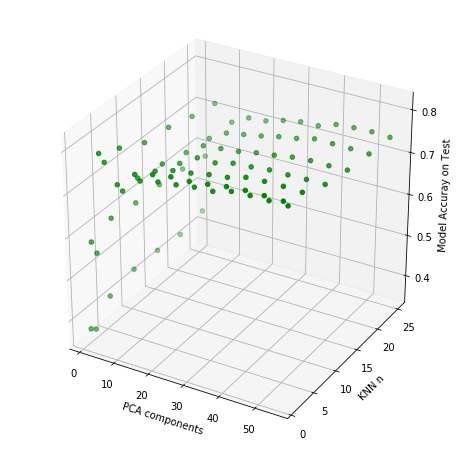

In [64]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(pca5_comp, knn5_comp, mod5_accu, c='g', marker='o')


ax1.set_xlabel('PCA components')
ax1.set_ylabel('KNN n')
ax1.set_zlabel('Model Accuray on Test')

plt.show()

In [79]:
# Using X_all_train to train KNN with n = 1, 2, 5, 10, 15, 20
# predict X_all_test, write to csv, submit to Kaggle for evaluation
pca_num = 10
knn_num = 20

pca5 = PCA(n_components=pca_num) 
ss5 = StandardScaler()
knn5 = KNeighborsClassifier(n_neighbors=knn_num)
pipe5 = Pipeline(steps = [
    ('pca', pca5),
    ('ss', ss5),
    ('knn', knn5)])
pipe5.fit(X_all_train, y_all_train)

pred = pipe5.predict(df_all_test)
ID = df_all_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})

import csv
with open('test_submission_knn5_p_'+ str(pca_num) +'_ss_n_' + str(knn_num) + '.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

## KNN5 Kaggle scores summary

### PCA = 2

- knn=1, score = 0.30100

- knn=2, score = 0.32729

- knn=5, score = 0.27951

- knn=10, score = 0.27085

- knn=20, score = 0.29783


### PCA = 5

- knn=1, score = 0.38851

- knn=2, score = 0.39139

- knn=5, score = 0.40282

- knn=10, score = 0.08341

- knn=20, score = 0.07438


### PCA = 10

- knn=1, score = 0.24169

- knn=2, score = 0.38731

- knn=5, score = 0.19156

- knn=10, score = 0.07077

- knn=20, score = 0.07002

